In [1]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
# import torch_xla
# import torch_xla.core.xla_model as xm

In [2]:
! pip install folium==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.6 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=82f7e28e7dbe55a2aecda182a1e20c63ee090ebc570c447a30da399542423168
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [3]:
!pip install datasets
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 35.7 MB/s 
     |████████████████████████████████| 140 kB 67.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.3 MB/s 
     |████████████████████████████████| 86 kB 7.3 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 212 kB 76.8 MB/s 
     |████████████████████████████████| 596 kB 63.3 MB/s 
     |████████████████████████████████| 127 kB 77.6 MB/s 
     |████████████████████████████████| 144 kB 52.7 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 53.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
    

# Importing Essential Libraries

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import os
import gc

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# set a seed value
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score

import transformers
from transformers import BertTokenizer, BertForSequenceClassification 
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW

import warnings
warnings.filterwarnings("ignore")


print(torch.__version__)

1.11.0+cu113


## Setting up the device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# # For TPU

# device = xm.xla_device()

# print(device)

cuda:0


# Load dataset using hugging face library

In [6]:
import pandas as pd
train_df = pd.read_excel('train.xlsx')
valid_df = pd.read_excel('valid.xlsx')
test_df = pd.read_excel('test.xlsx')

In [7]:
train_df.head()

,source,targets,category
0,"When news is brought to one of them, of (the b...",و چون یکی از آنان را به [ولادت] دختر مژده دهند...,quran
1,After them repaired Zadok the son of Immer ove...,و چون دشمنان ما شنیدند که ما آگاه شده‌ایم و خد...,bible
2,And establish regular prayers at the two ends ...,و نماز را در دو طرف روز و ساعات نخستین شب برپا...,quran
3,"And it came to pass, that, when I was come aga...",و فرمود تا مدعیانش نزد تو حاضر شوند؛ و از او ب...,bible
4,"Ah woe, that Day, to the Rejecters of Truth!",وای در آن روز بر تکذیب کنندگان!,quran


## Generating some samples

In [8]:
train_df['source'][0]

'When news is brought to one of them, of (the birth of) a female (child), his face darkens, and he is filled with inward grief!'

In [9]:
train_df['targets'][0]

'و چون یکی از آنان را به [ولادت] دختر مژده دهند [از شدت خشم] چهره\u200cاش سیاه گردد، ودرونش از غصه واندوه لبریز و آکنده شود!!'

In [10]:
len(train_df)

12600

In [11]:
train_df['category'].value_counts()

quran    4200
bible    4200
mizan    4200
Name: category, dtype: int64

In [12]:
test_df['category'].value_counts()

mizan    900
bible    900
quran    900
Name: category, dtype: int64

In [13]:
valid_df['category'].value_counts()

bible    900
quran    900
mizan    900
Name: category, dtype: int64

## Concatenating features in our dataset

In [14]:
train_df['category'] = train_df['category'].map({'quran':0 , 'bible' : 1 , 'mizan' : 2})
test_df['category'] = test_df['category'].map({'quran':0 , 'bible' : 1 , 'mizan' : 2})
valid_df['category'] = valid_df['category'].map({'quran':0 , 'bible' : 1 , 'mizan' : 2})

In [15]:
train_df.columns = ['sent1','sent2','label']
test_df.columns = ['sent1','sent2','label']
valid_df.columns = ['sent1','sent2','label']

In [16]:
train_df.head()

,sent1,sent2,label
0,"When news is brought to one of them, of (the b...",و چون یکی از آنان را به [ولادت] دختر مژده دهند...,0
1,After them repaired Zadok the son of Immer ove...,و چون دشمنان ما شنیدند که ما آگاه شده‌ایم و خد...,1
2,And establish regular prayers at the two ends ...,و نماز را در دو طرف روز و ساعات نخستین شب برپا...,0
3,"And it came to pass, that, when I was come aga...",و فرمود تا مدعیانش نزد تو حاضر شوند؛ و از او ب...,1
4,"Ah woe, that Day, to the Rejecters of Truth!",وای در آن روز بر تکذیب کنندگان!,0


In [17]:
valid_df.head()

,sent1,sent2,label
0,"And there came out a fire from the LORD, and c...",تا برای بنی‌اسرائیل یادگارباشد تا هیچ غریبی که...,1
1,And out of them shall proceed thanksgiving and...,ویهودا و تمامی شهرهایش با هم و فلاحان و آنانی ...,1
2,So We sent against them a furious Wind through...,سرانجام تندبادی سخت و سرد در روزهایی شوم بر آن...,0
3,"""And drink Boiling Water on top of it:",و روی آن از آب جوشان خواهید نوشید،,0
4,"I was starting to get sleepythough, according ...",داشت خوابم می‌گرفت اگرچه، به گفته‌ی ادوارد نصف...,2


In [18]:
train_df = train_df[(train_df['sent1'].str.split().str.len() > 0) & (train_df['sent2'].str.split().str.len() > 0)]
valid_df = valid_df[(valid_df['sent1'].str.split().str.len() > 0) & (valid_df['sent2'].str.split().str.len() > 0)]

# XLM-RoBERTa Vocabulary

In [19]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

MODEL_TYPE = 'xlm-roberta-base'

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [20]:
len(tokenizer)

250002

In [21]:
tokens = tokenizer.tokenize('Heyy There!! See some boys are playing in rain')

print(tokens)

['▁Hey', 'y', '▁There', '!!', '▁See', '▁some', '▁boys', '▁are', '▁playing', '▁in', '▁rain']


In [22]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[28240, 53, 8622, 1146, 6872, 3060, 115982, 621, 75169, 23, 102044]


In [23]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

In [24]:
print('bos_token_id <s>:', tokenizer.bos_token_id)
print('eos_token_id </s>:', tokenizer.eos_token_id)
print('sep_token_id </s>:', tokenizer.sep_token_id)
print('pad_token_id <pad>:', tokenizer.pad_token_id)

bos_token_id <s>: 0
eos_token_id </s>: 2
sep_token_id </s>: 2
pad_token_id <pad>: 1


# How to use a tokenizer to create XLM-RoBERTa input ?

In [25]:


MAX_LEN = 15

sentence1 = 'Hello there.'
sentence2 = 'How are you?'

encoded_dict = tokenizer.encode_plus(
            sentence1, sentence2,      
            add_special_tokens = True,
            max_length = MAX_LEN,     
            pad_to_max_length = True,
            return_attention_mask = True,
            truncation=True,   
            return_tensors = 'pt' # return pytorch tensors
       )


encoded_dict

{'input_ids': tensor([[    0, 35378,  2685,     5,     2,     2, 11249,   621,   398,    32,
             2,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])}

In [26]:
tokenizer.tokenize(sentence1)

['▁Hello', '▁there', '.']

In [27]:
tokenizer.tokenize(sentence2)

['▁How', '▁are', '▁you', '?']

In [28]:
input_ids = encoded_dict['input_ids'][0]
att_mask = encoded_dict['attention_mask'][0]

# These are torch tensors.
print(input_ids)
print(att_mask)

tensor([    0, 35378,  2685,     5,     2,     2, 11249,   621,   398,    32,
            2,     1,     1,     1,     1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


In [29]:

a = tokenizer.decode(input_ids,
                skip_special_tokens=False)

b = tokenizer.decode(input_ids,
                skip_special_tokens=True)

print(a)
print(b)

<s> Hello there.</s></s> How are you?</s><pad><pad><pad><pad>
Hello there. How are you?


## Overflowing tokens and Stride

In [30]:
MAX_LEN = 15 # This value could be set as 256, 512 etc.

sentence1 = 'Hello there. How are you? Have a nice day. This is a test?'


encoded_dict = tokenizer.encode_plus(
            sentence1,                
            max_length = MAX_LEN,
            stride=0,
            pad_to_max_length = True,
            return_overflowing_tokens=True,
            truncation=True
       )


encoded_dict

{'overflowing_tokens': [83, 10, 3034, 32], 'num_truncated_tokens': 4, 'input_ids': [0, 35378, 2685, 5, 11249, 621, 398, 32, 31901, 10, 26267, 5155, 5, 3293, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Totally 19 tokens (4 tokens are considered as overflowing_tokens)

In [31]:
input_ids = encoded_dict['input_ids']
a = tokenizer.decode(input_ids,
                skip_special_tokens=False)
print(a ,'\n')

<s> Hello there. How are you? Have a nice day. This</s> 



In [32]:
MODEL_TYPE = 'xlm-roberta-base'


L_RATE = 3e-5
MAX_LEN = 128

NUM_EPOCHS = 3
BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

NUM_CORES
#torch.cuda.memory_summary(device=None, abbreviated=False)

2

In [33]:
# #For GPU

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print(device)

In [34]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# xlm-roberta-large
print('Loading XLMRoberta tokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)

Loading XLMRoberta tokenizer...


In [35]:
train_df.iloc[0]['sent1']

'When news is brought to one of them, of (the birth of) a female (child), his face darkens, and he is filled with inward grief!'

In [36]:
class CompDataset(Dataset):

    def __init__(self, df):
        self.df_data = df



    def __getitem__(self, index):

        # get the sentence from the dataframe
        sentence1 = self.df_data.iloc[index]['sent1']
        sentence2 = self.df_data.iloc[index]['sent2']

        # Process the sentence
        # ---------------------

        encoded_dict = tokenizer.encode_plus(
                    sentence1, sentence2,           # Sentences to encode.
                    add_special_tokens = True,      # Add the special tokens.
                    max_length = MAX_LEN,           # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',          # Return pytorch tensors.
                    truncation=True
               )
        
        # These are torch tensors.
        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        
        # Convert the target to a torch tensor
        target = torch.tensor(self.df_data.iloc[index]['label'])

        sample = (padded_token_list, att_mask, target)


        return sample


    def __len__(self):
        return len(self.df_data)
    
    
    
    
    

class TestDataset(Dataset):

    def __init__(self, df):
        self.df_data = df



    def __getitem__(self, index):

        # get the sentence from the dataframe
        sentence1 = self.df_data.iloc[index]['sent1']
        sentence2 = self.df_data.iloc[index]['sent2']

        # Process the sentence
        # ---------------------

        encoded_dict = tokenizer.encode_plus(
                    sentence1, sentence2,           # Sentence to encode.
                    add_special_tokens = True,      # Add the special tokens.
                    max_length = MAX_LEN,           # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',
                    truncation=True          # Return pytorch tensors.
               )
        
        # These are torch tensors.
        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        
               

        sample = (padded_token_list, att_mask)


        return sample


    def __len__(self):
        return len(self.df_data)

In [37]:

train_data = CompDataset(train_df)
val_data = CompDataset(valid_df)
test_data = TestDataset(test_df)

In [38]:
train_dataloader = DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_CORES
                                      )

val_dataloader = DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_CORES
                                      )

test_dataloader = DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_CORES
                                       )



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

394
85
85


In [39]:
# Get one train batch
import transformers
transformers.logging.set_verbosity_error()
padded_token_list, att_mask, target = next(iter(train_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(target.shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [40]:
# Get one test batch

padded_token_list, att_mask = next(iter(test_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)

torch.Size([32, 128])
torch.Size([32, 128])


In [41]:
from transformers import XLMRobertaForSequenceClassification,AdamW

model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_TYPE, 
    num_labels = 3, # The number of output labels. 2 for binary classification.
)

# Send the model to the device.
model.to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## Testing The Model

In [42]:
# # Create a batch of train samples
# # We will set a small batch size of 8 so that the model's output can be easily displayed.

# train_dataloader = DataLoader(train_data,
#                                         batch_size=8,
#                                         shuffle=True,
#                                        num_workers=NUM_CORES)

# b_input_ids, b_input_mask, b_labels = next(iter(train_dataloader))

# print(b_input_ids.shape)
# print(b_input_mask.shape)
# print(b_labels.shape)

In [43]:

# batch = next(iter(train_dataloader))

# # Send the data to the device
# b_input_ids = batch[0].to(device)
# b_input_mask = batch[1].to(device)
# b_labels = batch[2].to(device)

# # Run the model
# outputs = model(b_input_ids, 
#                 attention_mask=b_input_mask, 
#                 labels=b_labels)

# # The ouput is a tuple (loss, preds).
# outputs

In [44]:
# preds = outputs[1].detach().cpu().numpy()

# y_true = b_labels.detach().cpu().numpy()
# y_pred = np.argmax(preds, axis=1)

# y_pred

In [45]:
# Define the optimizer
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8 
            )

In [47]:

#import random
# Set the seed.
seed_val = 101

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []


# For each epoch...
for epoch in range(0, NUM_EPOCHS):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))
    

    stacked_val_labels = []
    targets_list = []

    # ========================================
    #               Training
    # ========================================
    
    print('Training...')
    
    # put the model into train mode
    model.train()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    for i, batch in enumerate(train_dataloader):
        
        train_status = 'Batch ' + str(i) + ' of ' + str(len(train_dataloader))
        
        print(train_status, end='\r')


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        


        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask,
                    labels=b_labels)
        
        # Get the loss from the outputs tuple: (loss, logits)
        loss = outputs[0]
        
        # Convert the loss from a torch tensor to a number.
        # Calculate the total loss.
        total_train_loss = total_train_loss + loss.item()
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        
        
        # Use the optimizer to update the weights.
        
        # Optimizer for GPU
        optimizer.step() 
        
        #Optimizer for TPU
        # https://pytorch.org/xla/
        #xm.optimizer_step(optimizer, barrier=True)

    
    print('Train loss:' ,total_train_loss)


    # ========================================
    #               Validation
    # ========================================
    
    print('\nValidation...')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)
    
    
    # Reset the total loss for this epoch.
    total_val_loss = 0
    

    for j, batch in enumerate(val_dataloader):
        
        val_status = 'Batch ' + str(j) + ' of ' + str(len(val_dataloader))
        
        print(val_status, end='\r')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)      


        outputs = model(b_input_ids, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        # Get the loss from the outputs tuple: (loss, logits)
        loss = outputs[0]
        
        # Convert the loss from a torch tensor to a number.
        # Calculate the total loss.
        total_val_loss = total_val_loss + loss.item()
        

        # Get the preds
        preds = outputs[1]


        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()
        
        # Move the labels to the cpu
        targets_np = b_labels.to('cpu').numpy()

        # Append the labels to a numpy list
        targets_list.extend(targets_np)

        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    
    # Calculate the validation accuracy
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)
    
    val_acc = accuracy_score(y_true, y_pred)
    
    
    print('Val loss:' ,total_val_loss)
    print('Val acc: ', val_acc)


    # Save the Model
    torch.save(model.state_dict(), 'model.pt')
    
    # Use the garbage collector to save memory.
    gc.collect()


======== Epoch 1 / 3 ========
Training...
Train loss: 86.8382795038633

Validation...
Val loss: 7.309636967023835
Val acc:  0.9803703703703703

======== Epoch 2 / 3 ========
Training...
Train loss: 19.58212022675434

Validation...
Val loss: 4.17649958160473
Val acc:  0.9892592592592593

======== Epoch 3 / 3 ========
Training...
Train loss: 12.658548310020706

Validation...
Val loss: 5.32082277329755
Val acc:  0.9874074074074074


# Make Prediction

In [48]:
for j, batch in enumerate(test_dataloader):
        
        inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
        
        print(inference_status, end='\r')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)


        outputs = model(b_input_ids, 
                attention_mask=b_input_mask)
        
        
        # Get the preds
        preds = outputs[0]


        # Move preds to the CPU
        preds = preds.detach().cpu().numpy()
        
        # Move the labels to the cpu
        targets_np = b_labels.to('cpu').numpy()

        # Append the labels to a numpy list
        targets_list.extend(targets_np)
        
        # Stack the predictions.

        if j == 0:  # first batch
            stacked_preds = preds

        else:
            stacked_preds = np.vstack((stacked_preds, preds))

In [49]:
stacked_preds

array([[-3.2465827, -3.34861  ,  6.425994 ],
       [-4.1241837,  6.702687 , -2.828245 ],
       [-3.831885 ,  6.572794 , -2.9803407],
       ...,
       [ 7.306066 , -3.9841528, -2.8537042],
       [-3.2872021, -3.4125319,  6.4838505],
       [-4.5647593,  6.721528 , -2.4340591]], dtype=float32)

In [50]:
# Take the argmax. This returns the column index of the max value in each row.

preds = np.argmax(stacked_preds, axis=1)

preds

array([2, 1, 1, ..., 0, 2, 1])

In [89]:
torch.softmax(torch.tensor(stacked_preds),dim=1).numpy()#.sum(dim=1)

array([[6.2979780e-05, 5.6871071e-05, 9.9988008e-01],
       [1.9856830e-05, 9.9990749e-01, 7.2565279e-05],
       [3.0287349e-05, 9.9989879e-01, 7.0971219e-05],
       ...,
       [9.9994874e-01, 1.2493905e-05, 3.8694183e-05],
       [5.7074121e-05, 5.0351115e-05, 9.9989259e-01],
       [1.2542278e-05, 9.9988186e-01, 1.0561551e-04]], dtype=float32)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
y_test, y_pred = test_df['label'].to_numpy(), preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=['quran' , 'bible'  , 'mizan']))

F1: 0.9881538410205132

              precision    recall  f1-score   support

       quran       0.98      0.99      0.99       900
       bible       1.00      0.98      0.99       900
       mizan       0.98      1.00      0.99       900

    accuracy                           0.99      2700
   macro avg       0.99      0.99      0.99      2700
weighted avg       0.99      0.99      0.99      2700



#AUC

In [95]:
nb_classes = 3
one_hot_targets = np.eye(nb_classes)[y_test.reshape(-1,1)]
one_hot_targets.reshape((len(y_test),-1))

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc_score(one_hot_targets.reshape((len(y_test),-1)), torch.softmax(torch.tensor(stacked_preds),dim=1).numpy(), multi_class='ovo', average='weighted')#, labels=['quran' , 'bible'  , 'mizan'])

0.9989836419753088

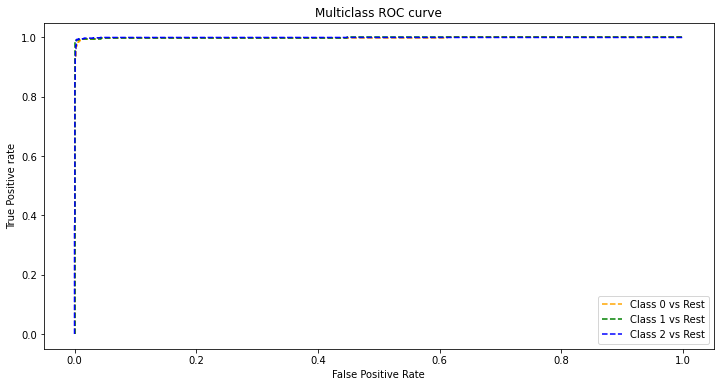

In [109]:
from IPython.core.pylabtools import figsize
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, torch.softmax(torch.tensor(stacked_preds),dim=1).numpy()[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(12,6))   
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [107]:
model_save_name = 'model_multilinual_xlm_roberta.pt'
path = F'/content/gdrive/MyDrive/Colab Notebooks/NLP(Faili)/CA#4/Trained_Models/{model_save_name}'
torch.save(model.state_dict(), path)